# *** power spectra binned plot from planck 2018 results ***

# import libraries

In [1]:
## import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import cm
from matplotlib.axes import Axes

from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import*
import pickle
from time import time
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.gridspec import GridSpec

import warnings
warnings.filterwarnings("ignore")

In [2]:
## drive
#from google.colab import drive
#drive.mount('/content/drive/')

# directory & paths for dataset files

In [3]:
## directory
directory = 'planck18_CMB_ps_dataset/'

In [4]:
## obs-full-unbinned dataset from planck18
TT_f_fname = 'COM_PowerSpect_CMB-TT-full_R3.01.txt'
TT_f       = pd.read_fwf(directory + TT_f_fname).drop(columns=['#'], axis=1)

TE_f_fname = 'COM_PowerSpect_CMB-TE-full_R3.01.txt'
TE_f       = pd.read_fwf(directory + TE_f_fname).drop(columns=['#'], axis=1)

EE_f_fname = 'COM_PowerSpect_CMB-EE-full_R3.01.txt'
EE_f       = pd.read_fwf(directory + EE_f_fname).drop(columns=['#'], axis=1)

## obs-binned (BestFit) data set from planck18
TT_b_fname = 'COM_PowerSpect_CMB-TT-binned_R3.01.txt'
TT_b       = pd.read_fwf(directory + TT_b_fname).drop(columns=['#'], axis=1)

TE_b_fname = 'COM_PowerSpect_CMB-TE-binned_R3.02.txt'
TE_b       = pd.read_fwf(directory + TE_b_fname).drop(columns=['#'], axis=1)

EE_b_fname = 'COM_PowerSpect_CMB-EE-binned_R3.02.txt'
EE_b       = pd.read_fwf(directory + EE_b_fname).drop(columns=['#'], axis=1)

In [5]:
## theory-unbinned dataset from planck18
theory_fname = 'COM_PowerSpect_CMB-base-plikHM-TTTEEE-lowl-lowE-lensing-minimum-theory_R3.01.txt'
theory       = pd.read_fwf(directory + theory_fname).drop(columns=['#','BB','PP'], axis = 1)
theory.rename(columns = {'L':'l'}, inplace = True)
theory['l']  = range(2, len(theory['TT'])+2)

In [6]:
calPlanck = 0.1000442E+01

theory['TT'] /= calPlanck**2
theory['TE'] /= calPlanck**2
theory['EE'] /= calPlanck**2

In [7]:
## theory dataset for the range highh(for theory-TE & -EE comp.s)
theoryhh = theory.iloc[:1995]

In [8]:
## to get the binned and weighted dataset 
## for full-unbinned and theory-unbinned datasets
def binned(array, deltal, weights=1):
    binned_array = []
    n_bin        = int(len(array)/deltal) + 1  
    for i in range(n_bin):
        binn     = array[deltal*i:deltal*(i+1)]
        average  = np.average(binn)
        binned_array.append(average)
    return binned_array

def binnedw(array, error, deltal):
    binned_array = []
    n_bin        = int(len(array)/deltal) + 1
    weights      = []
    for i in range(n_bin):
        binn         = array[deltal*i:deltal*(i+1)]
        binn_error   = error[deltal*i:deltal*(i+1)]
        binn_weights = 1/binn_error**2
        average      = np.average(binn, weights=binn_weights)
        binned_array.append(average)
    return binned_array

In [9]:
deltal = 30

In [10]:
## get the binned and weighted dataset for full-unbinned high dataset
TT_bf = pd.DataFrame()
TT_bf['l']    = binned(TT_f['l'], deltal)
TT_bf['Dl']   = binnedw(TT_f['Dl'], TT_f['+dDl'], deltal)
TT_bf['-dDl'] = binned(TT_f['-dDl'], deltal)
TT_bf['+dDl'] = binned(TT_f['+dDl'], deltal)

TE_bf = pd.DataFrame()
TE_bf['l']    = binned(TE_f['l'], deltal)
TE_bf['Dl']   = binnedw(TE_f['Dl'], TE_f['+dDl'], deltal)
TE_bf['-dDl'] = binned(TE_f['-dDl'], deltal)
TE_bf['+dDl'] = binned(TE_f['+dDl'], deltal)

EE_bf = pd.DataFrame()
EE_bf['l']    = binned(EE_f['l'], deltal)
EE_bf['Dl']   = binnedw(EE_f['Dl'], EE_f['+dDl'], deltal)
EE_bf['-dDl'] = binned(EE_f['-dDl'], deltal)
EE_bf['+dDl'] = binned(EE_f['+dDl'], deltal)

In [11]:
## get the binned and weighted dataset for full-unbinned high dataset
theory_b = pd.DataFrame()
theory_b['l']   = binned(theory['l'], deltal)
theory_b['TT']  = binned(theory['TT'], deltal)
theory_b['TE']  = binned(theory['TE'], deltal)
theory_b['EE']  = binned(theory['EE'], deltal)

theory_bhh = pd.DataFrame()
theory_bhh['l']   = binned(theoryhh['l'], deltal)
theory_bhh['TT']  = binned(theoryhh['TT'], deltal)
theory_bhh['TE']  = binned(theoryhh['TE'], deltal)
theory_bhh['EE']  = binned(theoryhh['EE'], deltal)

In [12]:
## defs. for plot
def Func(ax, s, f):
    for axis in ax_ll:
        axis.set_xscale('log')
        axis.set_xlim([2, 30])
        axis.spines['right'].set_visible(False)
        axis.set_xticks([2, 10, 30])
        axis.set_xticklabels(['2','10','30'])
        
    for axis in ax_hl:
        axis.set_xlim([30, 2550])
        axis.spines['left'].set_visible(False)
        
    for axis in ax[0]: 
        axis.set_xticks([])
        axis.set_xticklabels([])
        axis.legend(loc='upper right', fontsize=9)
        
    for axis in ax[1]: 
        axis.axhline(0, color='lime', lw=1.3) 
        axis.legend(loc='upper right', fontsize=9)        
    
    ax_hl[0].axvline(30, color='0.5', linestyle='--', lw=1.3)      
    ax_hl[1].axvline(30, color='0.5', linestyle='--', lw=1.3) 
        
    #ax_hl[0].set_yticks([])
    ax_hl[0].yaxis.set_ticks_position('right')  
    
    #ax_hl[1].set_yticks([])
    ax_hl[1].yaxis.set_ticks_position('right')      

# plot

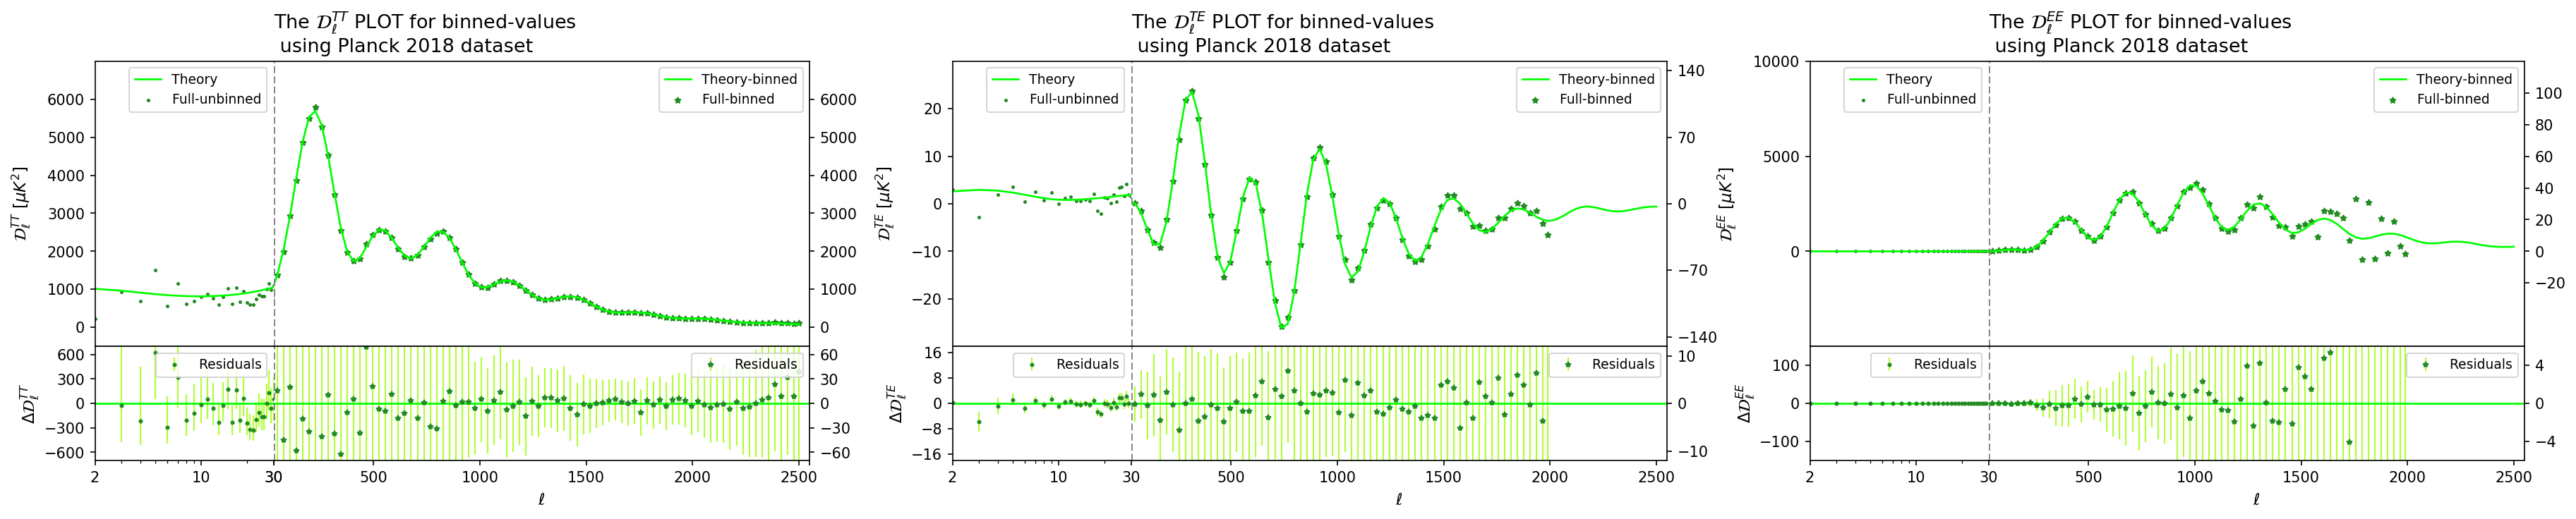

In [13]:
## plot
fig = plt.subplots(2, 3, figsize=(27, 5), dpi=150, sharex='col', sharey='row', 
                   gridspec_kw={'hspace':0.0, 'wspace':0.2})
d   = 1/40

##**********************************************
## For TT-ps plot
##**********************************************
s, f = 1.0, 11.0
gs1  = GridSpec(nrows=7, ncols=4)
gs1.update(left=s*d, right=f*d, wspace=0.0, hspace=0.0)

ax1 = plt.subplot(gs1[0:5, 0:1])
ax2 = plt.subplot(gs1[0:5, 1:4])
ax3 = plt.subplot(gs1[5:8, 0:1])
ax4 = plt.subplot(gs1[5:8, 1:4])
ax  = np.array([[ax1, ax2], [ax3, ax4]])

ax_ll = ax[:, 0]
ax_hl = ax[:, 1]

ax_ll[0].plot(theory['l'],   theory['TT'],   color='lime', lw=1.3, alpha=1, label='Theory')
ax_ll[0].scatter(TT_f['l'],  TT_f['Dl'],     s=2.0, color='forestgreen', alpha=1, label='Full-unbinned')
ax_hl[0].plot(theory_b['l'], theory_b['TT'], color='lime', lw=1.3, alpha=1, label='Theory-binned')
ax_hl[0].scatter(TT_bf['l'], TT_bf['Dl'],    s=15.0, marker=(5, 1), color='forestgreen', alpha=1, label='Full-binned')

ax_ll[1].errorbar(TT_f['l'], TT_f['Dl']-theory['TT'],
                  yerr=[TT_f['-dDl'], TT_f['+dDl']], ecolor='greenyellow', lw=1.0,
                  fmt='o', color='forestgreen', ms=1.9, alpha=1, label='Residuals')
ax_hl[1].errorbar(TT_bf['l'], TT_bf['Dl']-theory_b['TT'],
                  yerr=[TT_bf['-dDl'], TT_bf['+dDl']], ecolor='greenyellow', lw=1.0,
                  fmt='*', color='forestgreen', ms=4, alpha=1, label='Residuals')

ax_ll[1].set_xlim([2, 30])
ax_ll[1].set_xticks([2, 10, 30])
ax_hl[1].set_xlim([30, 2550])
ax_hl[1].set_xticks([30, 500, 1000, 1500, 2000, 2500, 2550])
ax_hl[1].set_xticklabels(['30','500', '1000', '1500', '2000', '2500'])

ax_ll[0].set_ylim([-500, 7000])
ax_ll[0].set_yticks([0, 1000, 2000, 3000, 4000, 5000, 6000])
ax_hl[0].set_ylim([-500, 7000])
ax_hl[0].set_yticks([0, 1000, 2000, 3000, 4000, 5000, 6000])

ax_ll[1].set_ylim([-700, 700])
ax_ll[1].set_yticks([-600, -300, 0, 300, 600])
ax_hl[1].set_ylim([-70, 70])
ax_hl[1].set_yticks([-60, -30, 0, 30, 60])

ax_hl[0].set_title('The $\mathcal{D}_{\ell}^{TT}$ PLOT for binned-values \n using Planck 2018 dataset', loc='left', fontsize=13)
ax_hl[1].set_xlabel('$\ell$', fontsize=11, labelpad=5)
ax_ll[0].set_ylabel('$\mathcal{D}_{\ell}^{TT} \\ [\mu K^{2}] $', fontsize=11, labelpad=10)
ax_ll[1].set_ylabel('$\Delta \mathcal{D}_{\ell}^{TT}$', fontsize=11, labelpad=2)

Func(ax, s, f)
##**********************************************

##**********************************************
## For TE-ps plot
##**********************************************
s, f = 13.0, 23.0
gs2  = GridSpec(nrows=7, ncols=4)
gs2.update(left=s*d, right=f*d, wspace=0.0, hspace=0.0)

ax1 = plt.subplot(gs2[0:5, 0:1])
ax2 = plt.subplot(gs2[0:5, 1:4])
ax3 = plt.subplot(gs2[5:8, 0:1])
ax4 = plt.subplot(gs2[5:8, 1:4])
ax  = np.array([[ax1, ax2], [ax3, ax4]])

ax_ll = ax[:, 0]
ax_hl = ax[:, 1]

ax_ll[0].plot(theory['l'],   theory['TE'],   color='lime', lw=1.3, alpha=1, label='Theory')
ax_ll[0].scatter(TE_f['l'],  TE_f['Dl'],     s=2.0, color='forestgreen', alpha=1, label='Full-unbinned')
ax_hl[0].plot(theory_b['l'], theory_b['TE'], color='lime', lw=1.3, alpha=1, label='Theory-binned')
ax_hl[0].scatter(TE_bf['l'], TE_bf['Dl'],    s=15.0,  marker=(5, 1), color='forestgreen', alpha=1, label='Full-binned')

ax_ll[1].errorbar(TE_f['l'], TE_f['Dl']-theory['TE'].iloc[:28],
                  yerr=[TE_f['-dDl'], TE_f['+dDl']], ecolor='greenyellow', lw=1.0,
                  fmt='o', color='forestgreen', ms=1.9, alpha=1, label='Residuals')
ax_hl[1].errorbar(TE_bf['l'], TE_bf['Dl']-theory_bhh['TE'],
                  yerr=[TE_bf['-dDl'], TE_bf['+dDl']], ecolor='greenyellow', lw=1.0,
                  fmt='*', color='forestgreen', ms=4, alpha=1, label='Residuals')

ax_ll[1].set_xlim([2, 30])
ax_ll[1].set_xticks([2, 10, 30])
ax_hl[1].set_xlim([30, 2550])
ax_hl[1].set_xticks([500, 1000, 1500, 2000, 2500])

ax_ll[0].set_ylim([-30, 30])
ax_ll[0].set_yticks([-20, -10, 0, 10, 20])
ax_hl[0].set_ylim([-150, 150])
ax_hl[0].set_yticks([-140, -70, 0, 70, 140])

ax_ll[1].set_ylim([-18, 18])
ax_ll[1].set_yticks([-16, -8, 0, 8, 16])
ax_hl[1].set_ylim([-12, 12])
ax_hl[1].set_yticks([-10, 0, 10])

ax_hl[0].set_title('The $\mathcal{D}_{\ell}^{TE}$ PLOT for binned-values \n using Planck 2018 dataset', loc='left', fontsize=13)
ax_hl[1].set_xlabel('$\ell$', fontsize=11, labelpad=5)
ax_ll[0].set_ylabel('$\mathcal{D}_{\ell}^{TE} \\ [\mu K^{2}] $', fontsize=11, labelpad=10)
ax_ll[1].set_ylabel('$\Delta \mathcal{D}_{\ell}^{TE}$', fontsize=11, labelpad=2)

Func(ax, s, f)
##**********************************************


##**********************************************
## For EE-ps plot
##**********************************************
s, f = 25.0, 35.0
gs3  = GridSpec(nrows=7, ncols=4)
gs3.update(left=s*d, right=f*d, wspace=0.0, hspace=0.0)

ax1 = plt.subplot(gs3[0:5, 0:1])
ax2 = plt.subplot(gs3[0:5, 1:4])
ax3 = plt.subplot(gs3[5:8, 0:1])
ax4 = plt.subplot(gs3[5:8, 1:4])
ax  = np.array([[ax1, ax2], [ax3, ax4]])

ax_ll = ax[:, 0]
ax_hl = ax[:, 1]

ax_ll[0].plot(theory['l'],   theory['EE'],   color='lime', lw=1.3, alpha=1, label='Theory')
ax_ll[0].scatter(EE_f['l'],  EE_f['Dl'],     s=2.0, color='forestgreen', alpha=1, label='Full-unbinned')
ax_hl[0].plot(theory_b['l'], theory_b['EE'], color='lime', lw=1.3, alpha=1, label='Theory-binned')
ax_hl[0].scatter(EE_bf['l'], EE_bf['Dl'],    s=15.0,  marker=(5, 1), color='forestgreen', alpha=1, label='Full-binned')

ax_ll[1].errorbar(EE_f['l'], EE_f['Dl']-theory['EE'].iloc[:28],
                  yerr=[EE_f['-dDl'], EE_f['+dDl']], ecolor='greenyellow', lw=1.0,
                  fmt='o', color='forestgreen', ms=1.9, alpha=1, label='Residuals')
ax_hl[1].errorbar(EE_bf['l'], EE_bf['Dl']-theory_bhh['EE'],
                  yerr=[EE_bf['-dDl'], EE_bf['+dDl']], ecolor='greenyellow', lw=1.0,
                  fmt='*', color='forestgreen', ms=4, alpha=1, label='Residuals')

ax_ll[1].set_xlim([2, 30])
ax_ll[1].set_xticks([2, 10, 30])
ax_hl[1].set_xlim([30, 2550])
ax_hl[1].set_xticks([500, 1000, 1500, 2000, 2500])

ax_ll[0].set_ylim([-5000, 10000])
ax_ll[0].set_yticks([0, 5000, 10000])
ax_hl[0].set_ylim([-60, 120])
ax_hl[0].set_yticks([-20, 0, 20, 40, 60, 80, 100])

ax_ll[1].set_ylim([-150, 150])
ax_ll[1].set_yticks([-100, 0, 100])
ax_hl[1].set_ylim([-6, 6])
ax_hl[1].set_yticks([-4, 0, 4])

ax_hl[0].set_title('The $\mathcal{D}_{\ell}^{EE}$ PLOT for binned-values \n using Planck 2018 dataset', loc='left', fontsize=13)
ax_hl[1].set_xlabel('$\ell$', fontsize=11, labelpad=5)
ax_ll[0].set_ylabel('$\mathcal{D}_{\ell}^{EE} \\ [\mu K^{2}] $', fontsize=11, labelpad=10)
ax_ll[1].set_ylabel('$\Delta \mathcal{D}_{\ell}^{EE}$', fontsize=11, labelpad=2)

Func(ax, s, f)
##**********************************************


#plt.savefig('power_spectra_planck2018_binned.pdf', bbox_inches='tight', dpi=150)